# Disruption prediction model training demo

 this notebook shows how to build a ML mode to predict disruption and
 evaluate its performance using JDDB performance sub package.
 
 this depends on the output FileRepo of basic_data_processing.py


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from jddb.performance import Result
from jddb.performance import Report
from jddb.file_repo import FileRepo




## build training data from file repo

In [6]:
# this function built nparray objects that can be used directly for the LightGBM training from the processed Filerepo
def matrix_build(shot_list, file_repo, tags):
    """
    get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y

    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# get disruption prediction result on shot using the output of the model on one shot
def get_shot_result(y_red, threshold_sample, start_time):
    """
    get shot result by a threshold and compare to start time
    Args:
        y_red:  result s from model
        threshold_sample: disruptive predict level

    Returns:
        shot predict result:The prediction result for the shot
        predict time: The time when disruption prediction is made or -1 for no disruption shot

    """
    binary_result = 1 * (y_pred >= threshold_sample)
    for k in range(len(binary_result) - 2):
        if np.sum(binary_result[k:k + 3]) == 3:
            predicted_dis_time = (k + 2) / 1000 + start_time
            predicted_dis = 1
            break
        else:
            predicted_dis_time = -1
            predicted_dis = 0
    return predicted_dis, predicted_dis_time



## Load all the data from the precessed filerepo and to the test and train split

### Load the data

In [7]:
test_file_repo = FileRepo(
    ".//data//jtext_data_train//$shot_2$00//")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])
# disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])


53


### Train test split

In [8]:
# train test split on shot not sample according to whether shots are disruption
# set test_size=0.5 to get 50% shots as test set
train_shots, test_shots, _, _ = \
    train_test_split(test_shot_list, is_disrupt, test_size=0.2,
                        random_state=1, shuffle=True, stratify=is_disrupt)

# # create x and y matrix for ML models
# # %%
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)
lgb_train = lgb.Dataset(X_train, y_train)  # create dataset for LightGBM
lgb_val = lgb.Dataset(X_test, y_test)  # create dataset for LightGBM


## Build the LightGBM model

In [9]:
# hyper-parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},

    'is_unbalance': True

}
evals_result = {}  # to record eval results for plotting
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets={lgb_train, lgb_val},
                evals_result=evals_result,
                early_stopping_rounds=30)


Starting training...
[1]	training's auc: 0.981264	valid_0's auc: 0.718115
Training until validation scores don't improve for 30 rounds
[2]	training's auc: 0.987736	valid_0's auc: 0.743042
[3]	training's auc: 0.991201	valid_0's auc: 0.797131
[4]	training's auc: 0.992872	valid_0's auc: 0.816225
[5]	training's auc: 0.993417	valid_0's auc: 0.833102
[6]	training's auc: 0.995221	valid_0's auc: 0.837178
[7]	training's auc: 0.995796	valid_0's auc: 0.833327
[8]	training's auc: 0.996484	valid_0's auc: 0.826451
[9]	training's auc: 0.996614	valid_0's auc: 0.832534
[10]	training's auc: 0.997677	valid_0's auc: 0.836251
[11]	training's auc: 0.997887	valid_0's auc: 0.836468
[12]	training's auc: 0.998054	valid_0's auc: 0.838838
[13]	training's auc: 0.998176	valid_0's auc: 0.834829
[14]	training's auc: 0.998271	valid_0's auc: 0.834775
[15]	training's auc: 0.99866	valid_0's auc: 0.838337
[16]	training's auc: 0.998754	valid_0's auc: 0.84514
[17]	training's auc: 0.999406	valid_0's auc: 0.84377
[18]	trainin

## Save the results for evaluation

save sample result to a dict, so when predicting shot with different trigging logic,

you don't have to re-infer the test shots

In [10]:
# create an empty result object
test_result = Result(r'..\_temp_test\test_result.csv')
sample_result = dict()

# generate predictions for each shot
shot_nos = test_shots  # shot list
shots_pred_disrurption = []  # shot predict result
shots_pred_disruption_time = []  # shot predict time
for shot in test_shots:
    X, _ = matrix_build([shot], test_file_repo, tag_list)
    # get sample result from LightGBM
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    sample_result.setdefault(shot, []).append(
        y_pred)  # save sample results to a dict

    # using the sample reulst to predict disruption on shot, and save result to result file using result module.
    time_dict = test_file_repo.read_labels(shot, ['StartTime'])
    predicted_disruption, predicted_disruption_time = get_shot_result(
        y_pred, .5, time_dict['StartTime'])  # get shot result by a threshold
    shots_pred_disrurption.append(predicted_disruption)
    shots_pred_disruption_time.append(predicted_disruption_time)

# add predictions for each shot to the result object
test_result.add(shot_nos, shots_pred_disrurption,
                shots_pred_disruption_time)
# get true disruption label and time
test_result.get_all_truth_from_file_repo(
    test_file_repo)

test_result.lucky_guess_threshold = .8
test_result.tardy_alarm_threshold = .005
test_result.calc_metrics()
test_result.save()
# print the results, the basic metric
print("precision = " + str(test_result.precision))
print("tpr = " + str(test_result.tpr))


precision = 0.8538129598189022
tpr = 0.8947368421052632


## get more metrics and figures for this model

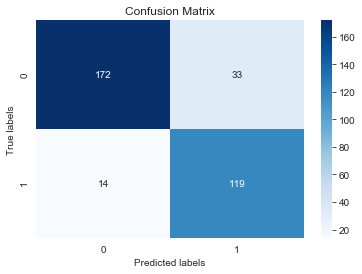

[[0.1, 0.3), [0.1, 0.3), [0.1, 0.3), [0.1, 0.3), [0.1, 0.3), ..., [0.1, 0.3), [0.1, 0.3), [0.05, 0.1), [0.05, 0.1), [0.05, 0.1)]
Length: 119
Categories (5, interval[float64, left]): [[-1.0, 0.002) < [0.002, 0.01) < [0.01, 0.05) < [0.05, 0.1) < [0.1, 0.3)]


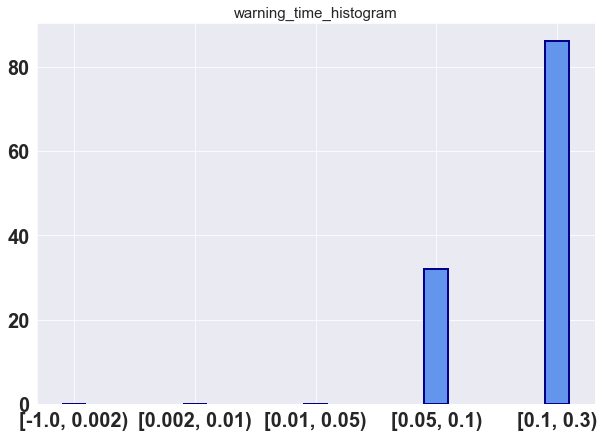

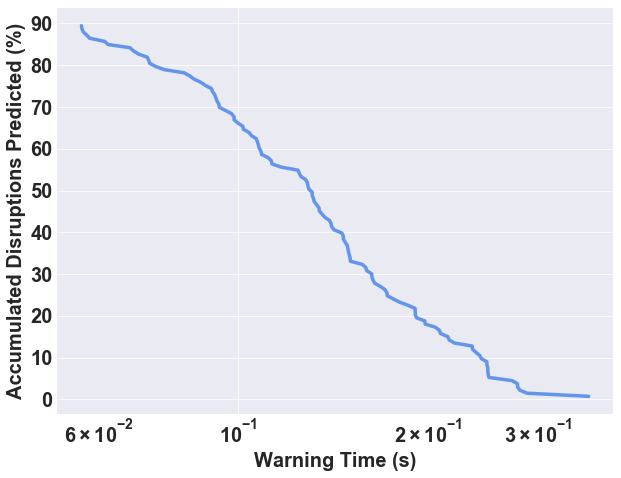

In [11]:
# and accumulate warning time.
sns.heatmap(test_result.confusion_matrix, annot=True, cmap="Blues", fmt='.0f')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
# plt.savefig(os.path.join('..//_temp_test//', 'Confusion Matrix.png'), dpi=300)
plt.show()

test_result.plot_warning_time_histogram(
    [-1, .002, .01, .05, .1, .3], '..//_temp_test//')
test_result.plot_accumulate_warning_time('..//_temp_test//')


## Scan the threshold, get a set of performance metrics for this model, plot ROC

E:\program\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\program\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\program\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\program\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  

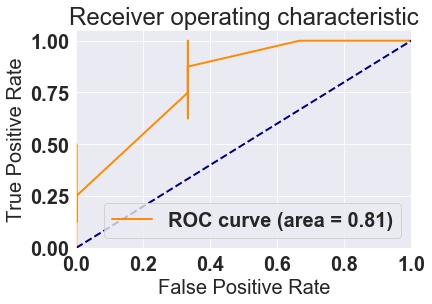

In [12]:
# scan the threshold, get many results, and add them to a report
# simply change different disruptivity triggering level and logic, to get many result.
test_report = Report('..//_temp_test//report.csv')
thresholds = np.linspace(0, 1, 50)
for threshold in thresholds:
    shot_nos = test_shots
    shots_pred_disrurption = []
    shots_pred_disruption_time = []
    for shot in test_shots:
        y_pred = sample_result[shot][0]
        time_dict = test_file_repo.read_labels(shot, ['StartTime'])
        predicted_disruption, predicted_disruption_time = get_shot_result(
            y_pred, threshold, time_dict['StartTime'])
        shots_pred_disrurption.append(predicted_disruption)
        shots_pred_disruption_time.append(predicted_disruption_time)
    # i dont save so the file never get created
    temp_test_result = Result('../_temp_test/temp_result.csv')
    temp_test_result.lucky_guess_threshold = .8
    temp_test_result.tardy_alarm_threshold = .001
    temp_test_result.add(shot_nos, shots_pred_disrurption,
                            shots_pred_disruption_time)
    temp_test_result.get_all_truth_from_file_repo(test_file_repo)

    # add result to the report
    test_report.add(temp_test_result, "thr=" + str(threshold))
    test_report.save()
# plot all metrics with roc
test_report.plot_roc('../_temp_test/')
